---
# &#127806; [Final Project Report] Agricultural Crop Price Prediction

<p align="right"> CS 247 Machine Learning </p>
<p align="right">December 18, 2022 | Angelica Kim </p>

---

### 1. Project Goal

This project employs neural-network-based models--Long Short-term Memory (LSTM)--to forecast the daily average price of crops across all agricultural wholesale markets in Korea. While the agricultural produce exhibit high price volatility, readily impacted by macroeconomic conditions and policits, there are seasonality and periodicity in crop prices due to life cycles of crops related to growth and harvest. Accurate crop price prediction would be extremely valuable in trading agricultural futures because it helps identify arbitrage opportunities.

### 2. Data Description

In this project, I analyze aggregate time series data that combines daily transaction information from wholesale and retail markets, daily weather in the primary growing areas, and monthly trades data for 37 crops from 2013 to 2016. The data was provided by an online artificial intelligence (AI) competition platform hosted by Korea Agro-Fisheries & Food Trade Corporation ([Link to data source](https://aifactory.space/competition/data/2091)). Note that I translated the variable names into English since the original data was from a source based in Korea.

#### Data Dictionary:

>1. `date`: Date
>2. `crop`: Type of crops encoded in numbers (0-36)    
> <strong>Price information (All price units are in Korean Won):</strong>   
>3. `daily_avg_price`: Daily average price of each crop across 32 wholesale markets in Korea     
>4. `daily_total_volume`: Total volume of each crop traded in 32 wholesale markets each day       
>5. `avg_price_low`: Daily average of prices that fall below the value of `daily_avg_price` on that day     
>6. `avg_price_high`: Daily average of prices that are higher than the value of `daily_avg_price` on that day            
>7.`low_price_volume`: Total volume of each crop whose price is lower than the `daily_avg_price` for that crop traded on that day       
>8. `high_price_volume`: Total volume of each crop whose price is higher than the `daily_avg_price` for that crop traded on that day        
> <strong>Wholesale and retail transaction-related variables: </strong>     
>9. `daily_max_wholesale_price`: Daily maximum price of each crop traded in 12 wholesale markets   
>10. `daily_avg_wholesale_price`: Daily average price of each crop traded in 12 wholesale markets    
>11. `daily_min_wholesale_price`: Daily minimum price of each crop traded in 12 wholesale markets    
>12. `daily_max_retail_price`: Daily maximum price of each crop traded in 45 retail markets    
>13. `daily_avg_retail_price`:  Daily average price of each crop traded in 45 retail markets     
>14. `daily_min_retail_price"`: Daily minimum price of each crop traded in 45 retail markets    
><strong>Trade-related variables:</strong>     
>15. `export_weight`: Weight of the crop exported, by month (in kilograms)            
>16. `export_amount_usd`: Value of export, by month (in US Dollars)      
>17. `import_weight`: Weight of the crop imported, by month (in kilograms)                  
>18. `import_amount_usd`: Value of import, by month (in US Dollars)     
>19. `trade_balance_usd`: The balance of trade, which is the difference between the value of exports and imports (in US Dollars)     
> <strong>Meteorological variables:</strong>     
>20. `area0_base_temp`: The base temperature of each crop at the first primary growing area, below which the crop no longer develops (in Celsius degrees)     
>21. `area0_max_temp`: Daily maximum temperature at the first primary growing area of each crop (in Celsius degrees)           
>22. `area0_min_temp`: Daily minimum temperature at the first primary growing area of each crop (in Celsius degrees)    
>23. `area0_avg_temp`: Daily average temperature at the first primary growing area of each crop (in Celsius degrees)    
>24. `area0_precip`: Daily precipitation amount at the first primary growing area of each crop (in milliliters)     
><em>There are two more sets of the same variables for two other primary growing areas.</em>

### 3. Related Work

There is an overflow of literature that performs stock price prediction using machine learning models. Taking into account the fact that the historical information has served as the basis of investment decisions in the finance industry, Wei employs Long Short-Term Memory (LSTM) neural network to perform stock price prediction (Wei, 2019). The model has proven effective for analyzing the time series since it uses the selective memory to keep track of the historical information. Since the data I'm using is also a time series that describes the daily average price of agricultural crops, I use LSTM models for crop price prediction.


<strong> Citations: </strong>
<li> Wei, Dou. “Prediction of Stock Price Based on LSTM Neural Network.” 2019 International Conference on Artificial Intelligence and Advanced Manufacturing (AIAM), 2019, https://doi.org/10.1109/aiam48774.2019.00113. </li>
<li> <em>FORECASTING: PRINCIPLES AND PRACTICE</em>, by Rob J Hyndman and George Athanasopoulos </li>
<li> <em> Machine Learning with PyTorch and Scikit-Learn</em>, by Sebastian Raschka, Yuxi (Hayden) Liu, and Vahid Mirjalili, Packt Publishing, 2022. </li>

---

# <font color = "green">Part I</font> - `Environment Setup`

In [3]:
import random
random.seed(247) # set seed for reproducibility

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from numpy import log
import math

import datetime
import glob
import zipfile

import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#turn off warnings
import warnings
warnings.filterwarnings(action='ignore')

>I train three LSTM models using GPUs on the [Amherst College HPC system](https://hpc.mghpcc.amherst.edu/). I used the **NVIDIA A5000 GPU** with 24GB of RAM and 64 streaming multiprocessors. When initializing the configuration of the kernel for this Jupyter notebook, I added a module `tensorflow2-extra-py39-cuda11.2-gcc9` to use the GPU implementation of the **tensorflow** package.

# <font color = "green">Part II </font> - `Data Preparation`

## 2.1 Import Data

In [1]:
print(os.getcwd())

/Users/angelica/Desktop/ML/final_project_AngelicaKim


In [4]:
df = pd.read_csv("./data.csv")

In [5]:
df.head()

,date,crop,daily_avg_price,daily_total_volume,avg_price_low,avg_price_high,low_price_volume,high_price_volume,daily_max_wholesale_price,daily_avg_wholesale_price,...,area1_base_temp,area1_max_temp,area1_min_temp,area1_avg_temp,area1_precip,area2_base_temp,area2_max_temp,area2_min_temp,area2_avg_temp,area2_precip
0,20130101,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.3,6.0,-4.9,-0.3,0.0,0.9,9.0,-1.3,4.4,0.0
1,20130102,0,20712.240909,22.0,4605.775000,40040.000000,12.0,10.0,180000.0,178800.0,...,-1.8,7.7,-2.3,3.7,0.0,3.5,10.0,2.4,5.4,0.0
2,20130103,0,3401.863678,541.0,2003.085396,7526.728102,404.0,137.0,180000.0,178800.0,...,4.4,6.8,-3.6,1.5,0.0,3.3,8.3,-3.4,2.7,0.0
3,20130104,0,6553.903226,279.0,2266.215190,8247.540000,79.0,200.0,180000.0,178800.0,...,-3.3,8.4,-4.3,1.9,0.0,-0.6,10.2,-1.0,5.8,0.0
4,20130105,0,4299.079157,1233.0,2882.419857,9705.626562,977.0,256.0,180000.0,178800.0,...,-4.2,8.4,-4.9,1.3,0.0,-0.6,8.4,-2.0,3.7,0.0


In [6]:
df.shape

(54057, 34)

## 2.2 Preprocessing

### Crop Selection

In [6]:
df["crop"].nunique()

37

There are 37 types of crops in the data. Since the goal of this project is to forecast their future price, I choose the one with the lowest price volatility to see how machine learning models perform in predicting relatively less volatile prices. The results from this crop could serve as the baseline for the ML-based crop price forecasting, and the models can be refined in the future to predict more volatile prices.     

I examine the standard deviation of `daily_avg_price` by crops to choose the one with the lowest price volatility.

In [7]:
df_sd = pd.DataFrame(df.groupby('crop')['daily_avg_price'].std().reset_index())
df_sd.rename(columns={"daily_avg_price":"daily_avg_price_sd"},inplace=True)
df_sd.sort_values('daily_avg_price_sd', ascending=True).head()

,crop,daily_avg_price_sd
9,9,237.444317
30,30,263.005588
29,29,280.030726
10,10,285.184146
28,28,288.760968


In [7]:
df2 = df[df["crop"].isin([9])].copy()

Since crop 9 has the lowest price volatility on a daily basis, I analyze the `daily_avg_price` of crop 9 in this project.

In [10]:
df2.drop(columns="crop",inplace=True)

In [11]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d')

Text(0.5, 1.0, 'Daily Average Price of Crop 9, 2013-2016')

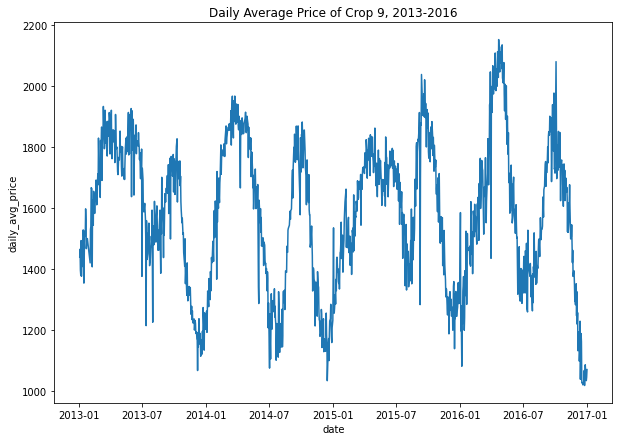

In [11]:
plt.figure(figsize=(10,7))
sns.lineplot(x = "date", y = "daily_avg_price", data = df2)
plt.title("Daily Average Price of Crop 9, 2013-2016")

The time series plot of the daily average price of crop 9 shows that the price fluctuates between 1000 KRW and 2200 KRW. Clearly, there are cycles in the time series: the price peaks around April and October, and the local minimums tend to occur around July and January. In other words, within a one-year cycle, the daily average price of crop 9 shows seasonality such that it rises in the spring and fall and falls in summer and winter. It can also be said that the price has a 6-month periodicity. Overall, it has a slightly increasing trend over time.

# <font color = "green">Part III </font> - `Methods`

In this project, I compare the performance of two models, AutoRegressive Integrated Moving Average (ARIMA) and Long Short-term Memory (LSTM), in predicting future prices. 

ARIMA is a classic time series prediction model used in economics. It is a mathematical model that forecasts time series using past values. The key idea behind the ARIMA model is to force the time series to be stationary, which means that the statistical properties behind time series remain constant over time. This does not mean that, for example, price remains constant over time, but it shows variations in a consistent fashion. Thus, a stationary time series has the properties that do not depend on the time at which the series is observed. By making a time series stationary, we let the model to learn more meaningful patterns. Think of a random variable that can be broken down into a repeating pattern and a random noise. What ARIMA does is to filter out the noise from the pattern and extrapolate it to the future to make predictions. When the model predicts a future value, it uses past values and past forecast errors as predictors.

ARIMA model takes 3 parameters (p, d, q): the orders for the autoregressive (AR), differencing, and moving average(MA) terms.   

1. Autoregressive: accounts for the fact that past values have an effect on current values    
    - p is the order of the AR term and refers to the numbrer of lags of the price to be used as predictors
    - p can be found by looking at **Partial Autocorrelation**, which measure the pure correlation between the price and each of its lags, after excluding the contributions from the intermediate lags.
2. Differencing (d): subtracts the current value from the previous to transform a time series into one that’s stationary 
    - d controls how much differencing should be done.
    - I run the **Augmented Dickey Fuller test** to check if the time series of `daily_avg_price` is stationary. The null hypothesis of the test is that the time series is non-stationary. If the p-value is small, we reject the null hypothesis.    
3. MA (q): predicts the future price based on the errors made on past forecasts. 
    - A future price at time t can be thought of as a weighted moving average of the past few forecast errors at t-1, t-2, and so on.
    - q can be determined by looking at autocorrelation.

### *What is LSTM? How is it different from RNN?*

Recurrent neural network (RNN) takes into account historical information to produce outputs in the network—it feeds the output from the previous step as input to the current step. This is achieved by the architecture of the RNN in which the hidden layer not only receives its input from the input layer of the current time step t but also from the hidden layer from the previous time step t-1.  

![RNN](RNN.png)

Because RNN remembers the previous inputs, it is not only useful for time series prediction but also works for any sequential data. However, the downside of RNN is that as it backpropagates the errors through time, the gradient becomes very small (or very large) if the weight of the recurrent edge is smaller than 1 (or greater than 1). This is where the vanishing (or exploding) gradient problems arise: the model stops updating the weights early even though the network is still not trained properly. LSTM mitigates this problem by introducing long-term memory into RNN.

The building block of an LSTM is a <strong>memory cell</strong>, and we can think of it as a replacement for the hidden layer in the RNN. The recurrent edge in the standard RNN now has the values associated with it, which are called the <strong>cell state</strong>. Instead of simply multiplying the output from the previous time step by weight factors to generate the input at the current time step, a memory cell modifies the cell state from the previous time step to obtain the cell state at the current time step. This process is controlled by <strong>gates</strong> using activation functions and simple element-wise multiplication and addtiion. There are three types of gates—input gate, output gate, and forget gate:

![RNN](LSTM.png)

1. The **forget gate** decides which information needs attention and which information should be suppressed. By doing so, it resets the cell state without letting it grow indefinitely as in the vanishing/exploding gradient problem.
    - The input data at the current time t and the outputs from the hidden units from the previous time step t-1 are passed into a sigmoid function to transform the values between 0 and 1

2. The **input gate** updates the cell state:
    - input gate: the input data at the current time t and the outputs from the hidden units from the previous time step t-1 are passed into a sigmoid function to transform the values between 0 and 1
    - candidate values: the same set of the input data at t and the hidden units at t-1 are passed into a tanh function to generate the between -1 and 1
    - input gate and candidate values are multiplied element-wise.

- The new cell state is then determined in two steps:
    1. Multiply the previous cell state with the forget gate--if the forget gate is 0, the previous cell state is *forgotten*.
    2. Add step 1 and the output from the input gate.

3. The **output gate** determines the values of the hidden state at the current time t:
    1.  the input data at the current time t and the outputs from the hidden units from the previous time step t-1 are passed through the sigmoid function
    2. the new cell state generated above is passed through the tanh function
    3. Multiply steps 1 and 2.

Likewise, gates manage how to represent the time series observed so far as inputs, what to forget about the series, how to combine new input with the past representation of the series, and what to output as a prediction.

For the LSTM model, I use the `CuDNNLSTM()` function, instead of the standard `LSTM()` function, from the **Keras** package that supports the GPU implementation in order to speed up the training.

# <font color = "green">Part IV </font> - Modeling & Results

## **1. [Benchmark Model]** ARIMA

We use ARIMA model as our benchmark for crop price prediction. The model forecasts the future price based on the past price--in particular, its own lagged values and the past forecast errors. Thus, I use only one feature--`daily_avg_price` and split the data into train and test sets on a temporal basis: the train data spans from 2013 to 2015 and the test data covers the year of 2016.

In [12]:
df_train = df2.iloc[0:1095,0:2] #2013~2015
df_test = df2.iloc[1095:,0:2] #2016

In [22]:
print("Train data dates:", df_train["date"].min(), df_train["date"].max())

Train data dates: 2013-01-01 00:00:00 2015-12-31 00:00:00


In [23]:
print("Test data dates:", df_test["date"].min(), df_test["date"].max())

Test data dates: 2016-01-01 00:00:00 2016-12-31 00:00:00


In [13]:
df_train.dropna(inplace=True)

In [14]:
df_test.dropna(inplace=True)

In [15]:
df_train.set_index('date',inplace=True)
df_test.set_index('date',inplace=True)

### 1.1 Determine the order of AR (p) based on Partial Autocorrelation Plot

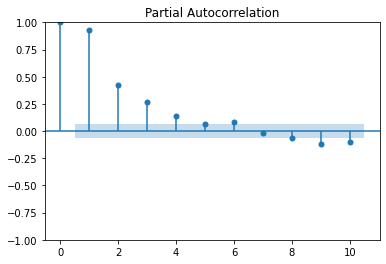

In [16]:
plot_pacf(df_train, lags=10)
plt.show()

The blue shade in the partial autocorrelation plot above represents the significance limit, so we choose the lags that are well above the limit. Thus, p=3.

### 1.2 Determine the differencing order (d) based on Augmented Dickey Fuller test

In [17]:
result = adfuller(df_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.893818
p-value: 0.000036


Since p-value is very small, we reject the null hypothesis that time series is not stationary. This result indicates that we don't need any differencing (d=0).

### 1.3 Determine the order of MA (q) based on autocorrelation

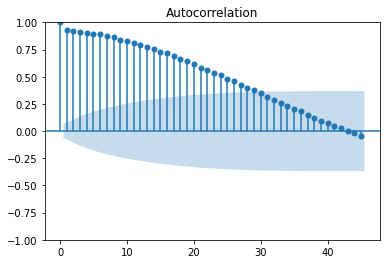

In [18]:
plot_acf(df_train, lags=45)
plt.show()

Just like in the partial autocorrelation plot, we choose the number of lags that are well above the significance line. I set q = 15.

In [19]:
model = ARIMA(df_train, order=(3, 0, 15))  
results = model.fit()  
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:        daily_avg_price   No. Observations:                  920
Model:                ARIMA(3, 0, 15)   Log Likelihood               -5208.399
Date:                Sun, 18 Dec 2022   AIC                          10456.797
Time:                        10:55:33   BIC                          10553.285
Sample:                             0   HQIC                         10493.617
                                - 920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1580.1097     42.051     37.576      0.000    1497.692    1662.527
ar.L1          0.9646      0.020     48.018      0.000       0.925       1.004
ar.L2          0.9857      0.017     56.666      0.0

The model summary shows that the coefficients of the MA terms except the first three are insignificant (according to the p-values). Thus, I fit the ARIMA model again with the order parameter (p=3,d=0,q=3)

In [20]:
model = ARIMA(df_train, order=(3, 0, 3))  
results = model.fit()  
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:        daily_avg_price   No. Observations:                  920
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -5215.409
Date:                Sun, 18 Dec 2022   AIC                          10446.818
Time:                        10:55:34   BIC                          10485.413
Sample:                             0   HQIC                         10461.546
                                - 920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1580.0413     35.502     44.506      0.000    1510.459    1649.624
ar.L1          0.9957      0.038     26.325      0.000       0.922       1.070
ar.L2          0.9620      0.073     13.152      0.0

After reducing the MA order to 3, all the coefficients are significant. Also, AIC decreased from 10456 to 10446. Akaike's Information Criterion (AIC) is useful for determining the order of the ARIMA model, especially p and q. The model with lower AIC has a better fit. 

I make predictions on the test data using the ARIMA model fitted above.

In [21]:
fc = results.forecast(len(df_test)) 
fc_series = pd.Series(fc.values,index=df_test.index)

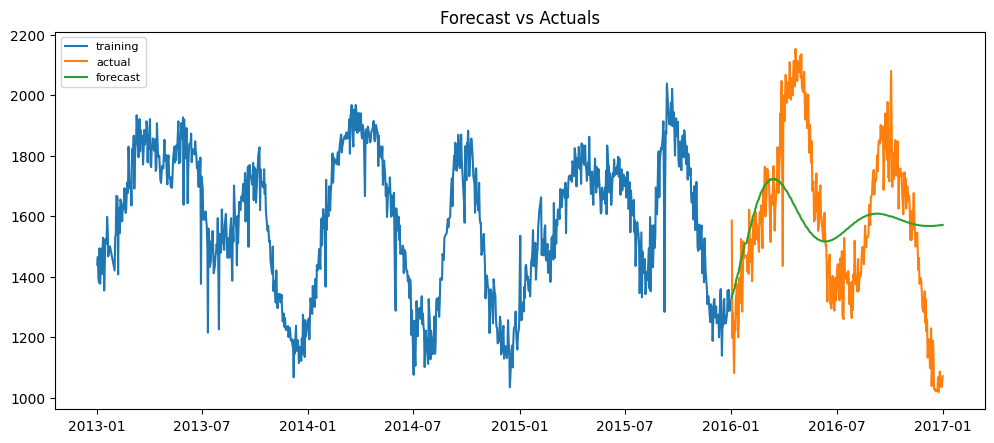

In [22]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
rmse = np.sqrt(np.mean(((fc - df_test.daily_avg_price.values) ** 2)))
rmse

244.01296338236153

In [24]:
df_test.daily_avg_price.values.mean()

1584.7522438022927

The blue line in the time series plots the training data from 2013 to 2015; the orange line are the observed values from 2016. The green line is the predictions made by the ARIMA model. The predictions are completely wrong, although they roughly capture the rise and fall. The RMSE is 244--the weighted average between the predictions and the observed values of 240 KRW is bad given the mean observed value is approximately 1580 KRW. 

## 2. Long Short-Term Memory (LSTM)

I fit two versions of LSTM models:    
>1. Model 1, like the ARIMA model, performs out-of-sample validation. In other words, it uses the past `daily_avg_price` as the only input to precict the future price. Specifically, the price in the past 365 days serves as the features and the price on the 366th day is the target variable. Then, I evaluate the model on the test data from 2016 and compare the performance with the ARIMA model in terms of Root Mean Squared Error (RMSE). RMSE is simply the squre root of the mean squared error (MSE), which measures the performance of the model in the same units as the target variable. I build two models with different number of LSTM neurons and hidden layers to examine the effect of the architecture on the predictive performance.
>2. For Model 2, I use 31 variables in the data, except `daily_avg_price`, as the features to predict the target variable `daily_avg_price`. In other words, I'm fitting the LSTM model for regression.

## 2.1 Model 1

### Scaling

In [25]:
df2.describe()

,daily_avg_price,daily_total_volume,avg_price_low,avg_price_high,low_price_volume,high_price_volume,daily_max_wholesale_price,daily_avg_wholesale_price,daily_min_wholesale_price,daily_max_retail_price,...,area1_base_temp,area1_max_temp,area1_min_temp,area1_avg_temp,area1_precip,area2_base_temp,area2_max_temp,area2_min_temp,area2_avg_temp,area2_precip
count,1231.000000,1.231000e+03,1231.000000,1229.000000,1.231000e+03,1.229000e+03,948.000000,948.000000,948.000000,941.000000,...,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,1581.290667,5.501773e+05,1392.668490,1761.036189,2.726075e+05,2.780216e+05,27482.067511,25964.124473,24508.227848,350.414453,...,11.489934,18.171782,8.730611,13.498762,4.336634,8.772671,18.195376,5.635473,11.444099,3.554037
std,237.444317,2.185310e+05,246.798840,232.095303,1.164834e+05,1.265502e+05,2658.761521,2356.035583,2437.318931,26.886688,...,8.574570,8.239250,9.014709,8.221565,12.538976,9.904275,9.800960,10.697238,9.903384,9.543287
min,1018.571102,9.100000e+02,173.014512,1123.351212,5.330000e+02,3.770000e+02,20000.000000,19440.000000,18000.000000,320.000000,...,-9.700000,-4.600000,-27.600000,-8.800000,0.000000,-16.800000,-7.900000,-19.800000,-12.600000,0.000000
25%,1395.748821,4.126875e+05,1208.874051,1589.956528,1.952320e+05,1.975580e+05,26000.000000,24400.000000,23000.000000,330.000000,...,4.200000,11.300000,1.000000,6.500000,0.000000,0.500000,9.900000,-3.300000,3.400000,0.000000
50%,1605.373727,5.210110e+05,1412.754551,1792.124169,2.603120e+05,2.562630e+05,27600.000000,26000.000000,25000.000000,346.000000,...,11.650000,19.100000,8.300000,13.600000,0.000000,9.000000,19.300000,5.500000,12.100000,0.000000
75%,1765.773709,6.544440e+05,1584.890107,1944.238560,3.303295e+05,3.317090e+05,29000.000000,27600.000000,26000.000000,360.000000,...,18.525000,24.600000,16.500000,20.300000,2.000000,17.100000,26.400000,14.600000,19.900000,1.900000
max,2152.829784,1.814885e+06,2080.469043,2322.995056,1.011587e+06,1.261923e+06,36000.000000,32800.000000,30000.000000,570.000000,...,30.700000,38.700000,26.000000,31.100000,155.500000,27.700000,38.500000,24.600000,30.100000,109.000000


Text(0.5, 1.0, 'Distribution of Daily Total Volume of Crop 9')

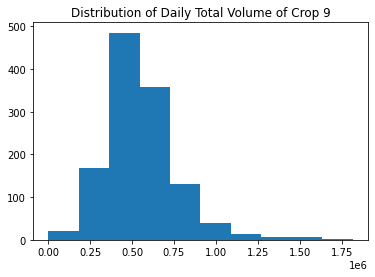

In [26]:
plt.hist(df2["daily_total_volume"])
plt.title('Distribution of Daily Total Volume of Crop 9')

I scale the data because the variables are on very different scales. However, I checked that some of the variables don't follow normal distributions. Instead of standardization, min-max scaling is used to normalize the data.

In [27]:
scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train_data = scaler.transform(df_train)
scaled_test_data = scaler.transform(df_test)

### Train, Test Split

I use the same train and test sets from the ARIMA model. However, they need to be reshaped because LSTM models require the input to have a 3D shape of *(batch size, length in time steps, and number of features)*.

In [28]:
X_train = []
y_train = []

for i in range(365, len(scaled_train_data)):
    X_train.append(scaled_train_data[i-365:i, 0])
    y_train.append(scaled_train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(555, 365)
(555, 365, 1)


In [29]:
data = np.append(scaled_train_data[scaled_train_data.shape[0] - 365: , :], scaled_test_data, axis=0)

X_test = []
y_test = df_test.values
for i in range(365, len(data)):
    X_test.append(data[i-365:i, 0])
    
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [30]:
X_test.shape

(311, 365, 1)

For Model 1, each batch contains the `daily_avg_price` value on any given day as `y` and its values in the past 365 days prior to that day as `X`. Given that the training data contains 920 rows spanning 2013-2015 with missing values dropped, there are 555 batches of X and y for the training set. The resulting input shape for model 1 would be (555, 365, 1). For the testing set, the last 365 days of the training set to use them as the input for the first few rows of the test data from 2016; the input shape would be (311, 365, 1).

### Define Network Architecture

In [31]:
n_input = X_train.shape[1] #time steps
n_features = 1 #number of features
model=Sequential()
# input layer
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, input_shape=(n_input,n_features), return_sequences=True))
# a single hidden layer using LSTM cells
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, return_sequences=False)) 
#output layer
model.add(Dense(1)) 

model.compile(optimizer='adam',loss='mse')
model.summary()

2022-12-18 10:55:35.483512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22378 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:25:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 365, 50)           10600     
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 50)                20400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


[W 2022-12-18 10:55:35,839.839 tensorflow] From /tmp/ipykernel_2864447/961965499.py:5: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.



The architecture of the first LSTM model consists of an input layer, a hidden layer, and an output layer. The first parameter in the `CuDNNLSTM()`, 50, represents the number of LSTM neurons in the layer. A large number of neruons give the model high dimensionality, capturing the upwards and downward trends. `return_sequence = True` for the input layer because each recurrent layer must receive a sequence as input.

In [32]:
model.fit(X_train, y_train, epochs=100, verbose=True) #I set verbose = True here for the illustration purposes, but I set to False onwards

Epoch 1/100


2022-12-18 10:55:37.176537: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


 9/18 [==============>...............] - ETA: 0s - loss: 0.0936

2022-12-18 10:55:37.832951: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


18/18 [==============================] - 2s 20ms/step - loss: 0.0598
Epoch 2/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0167
Epoch 3/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0116
Epoch 4/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0095
Epoch 5/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0078
Epoch 6/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0065
Epoch 7/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0064
Epoch 8/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0066
Epoch 9/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0062
Epoch 10/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0065
Epoch 11/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0067
Epoch 12/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0065
Epoch 13/100
18/18 [=================

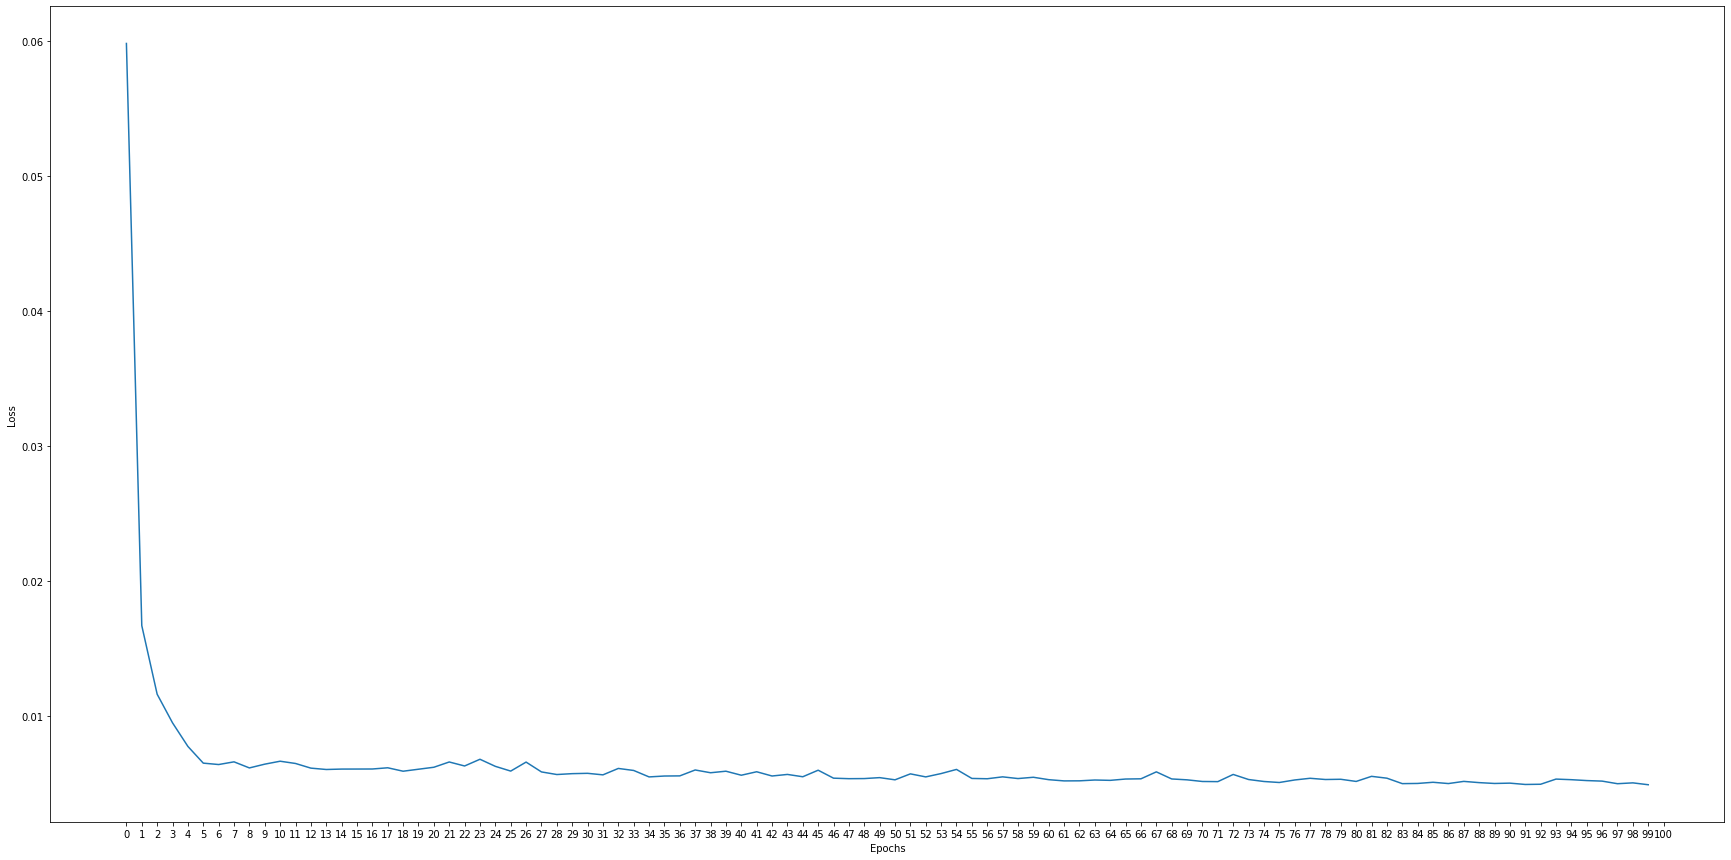

In [33]:
losses_lstm = model.history.history['loss']
plt.figure(figsize=(30,15))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,101,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

When the model is trained over 100 epochs, the MSE plummets at epoch 2 and converges to 0 over time.

I use the model to perform predictions on the test data. Since the data is normalized, predictions made on min-max scale would be transformed back to their original units for interpretation.

### Prediction

In [34]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
df_test['Predictions'] = predictions

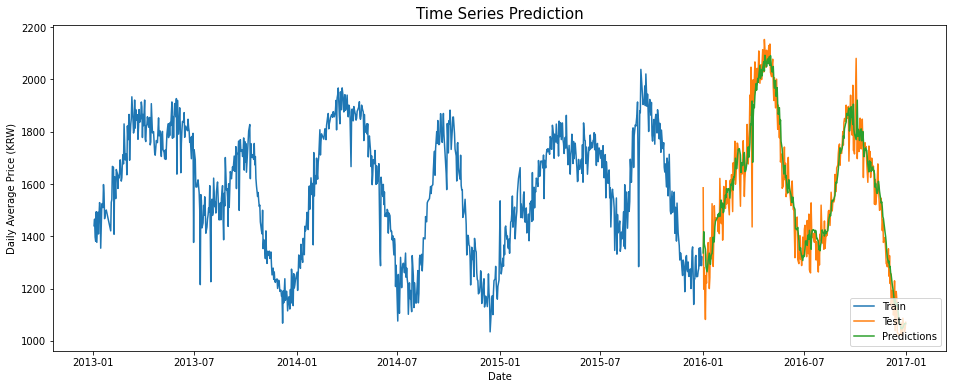

In [35]:
plt.figure(figsize=(16,6))
plt.title('Time Series Prediction', fontsize = 15)
plt.xlabel('Date')
plt.ylabel('Daily Average Price (KRW)')
plt.plot(df_train)
plt.plot(df_test[['daily_avg_price', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [36]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

82.90278187678373

Overall, the LSTM model predicts the price fairly well. The general shape of the prediction series matches the observed series. However, it doesn't capture the daily fluctuations. The RMSE of 82 is clearly an improvement from the benchmark of 244 from the ARIMA model. 

I fit a deeper LSTM model, i.e. with additional hidden layers and more LSTM cells, to see if higher complexity helps predict the fluctuations in price on a daily basis.

In [37]:
# more neurons and hidden layers
n_input = X_train.shape[1]
n_features = 1
model2=Sequential()
# input layer
model2.add(tf.compat.v1.keras.layers.CuDNNLSTM(100, input_shape=(n_input,n_features), return_sequences=True))
# hidden layer 1
model2.add(tf.compat.v1.keras.layers.CuDNNLSTM(100, return_sequences=True)) 
# hidden layer 2
model2.add(tf.compat.v1.keras.layers.CuDNNLSTM(100, return_sequences=False)) 
#output layer
model2.add(Dense(1)) 

model2.compile(optimizer='adam',loss='mse')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 365, 100)          41200     
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 365, 100)          80800     
                                                                 
 cu_dnnlstm_4 (CuDNNLSTM)    (None, 100)               80800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 202,901
Trainable params: 202,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
model2.fit(X_train, y_train, epochs=100, verbose=False)

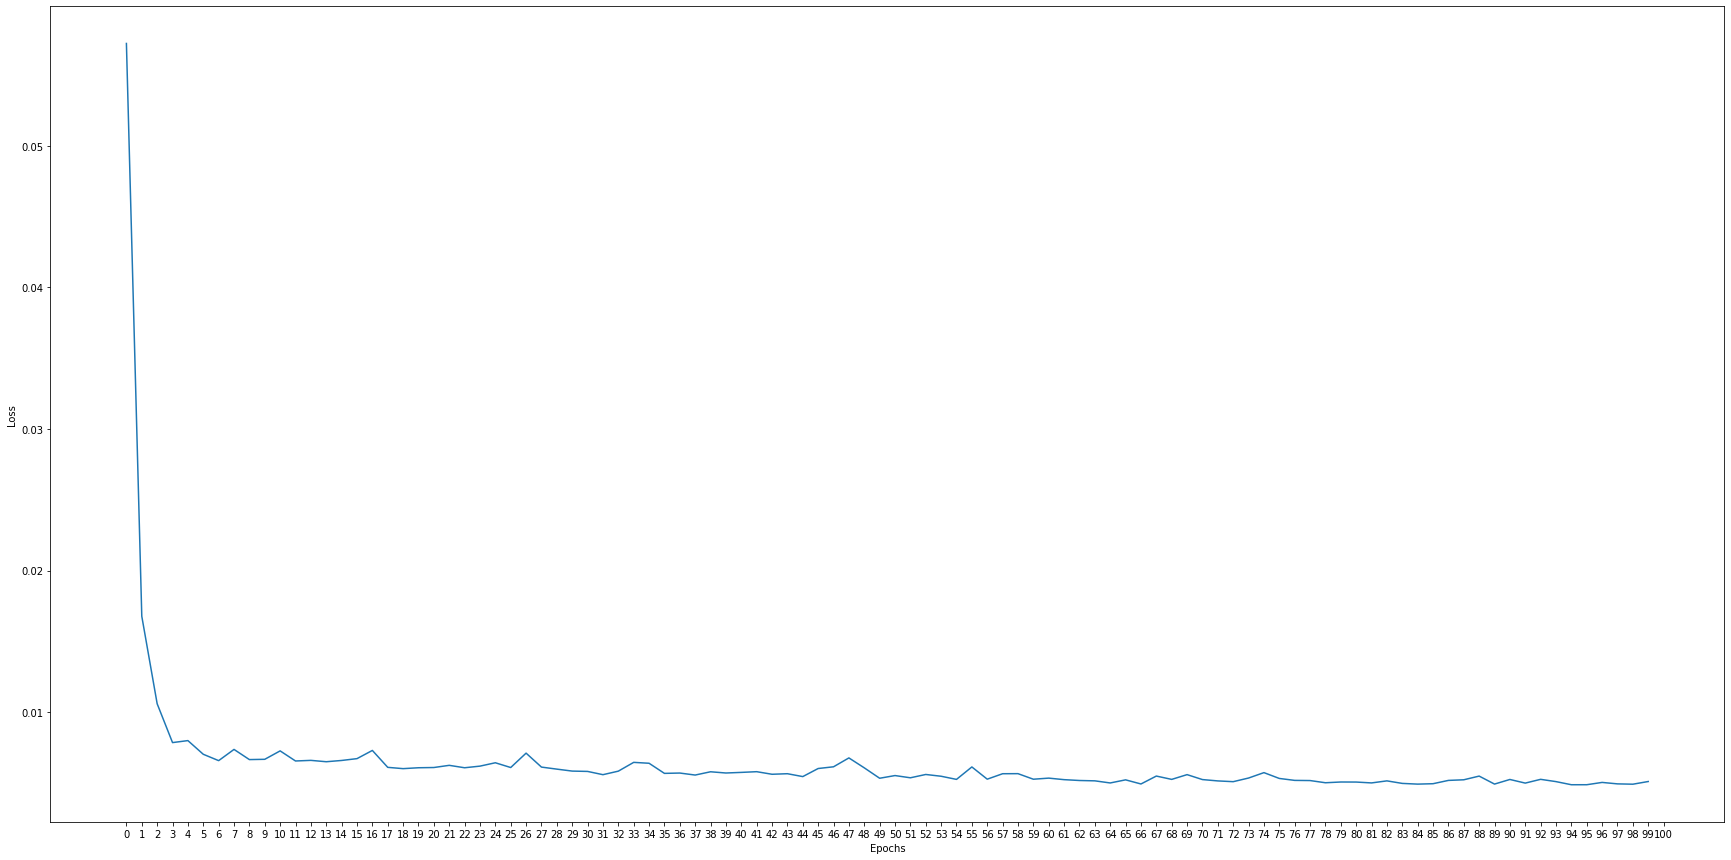

In [39]:
losses_lstm = model2.history.history['loss']
plt.figure(figsize=(30,15))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,101,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

As in the first model, the MSE converges to 0 over time but the y-axis shows that this model has slightly lower MSE than the first one.

In [40]:
predictions = model2.predict(X_test)
predictions = scaler.inverse_transform(predictions)
df_test['Predictions2'] = predictions

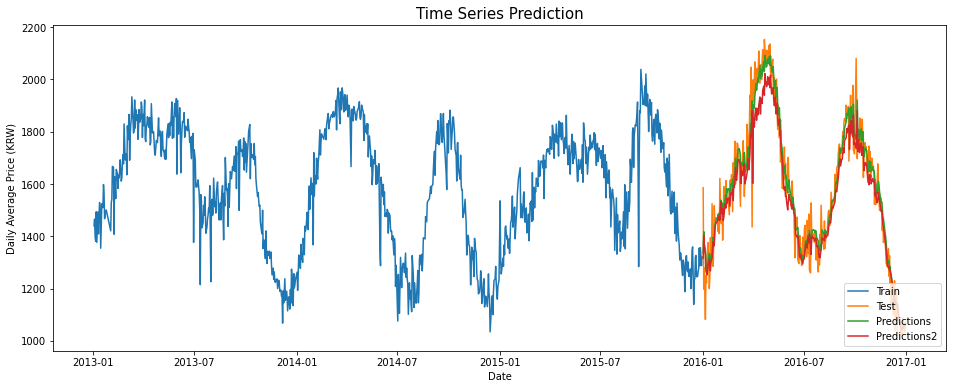

In [41]:
plt.figure(figsize=(16,6))
plt.title('Time Series Prediction', fontsize = 15)
plt.xlabel('Date')
plt.ylabel('Daily Average Price (KRW)')
plt.plot(df_train)
plt.plot(df_test[['daily_avg_price', 'Predictions', 'Predictions2']])
plt.legend(['Train', 'Test', 'Predictions', 'Predictions2'], loc='lower right')
plt.show()

In [42]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

94.87283732535127

We confirm that increasing the model complexity doesn't necessarily improve the performance. In fact, RMSE is higher than that of the model with a single hidden layer. This may be presumably due to the vast search space. It is difficult for the complex models to find the optimal solution because they are capable of learning all the underlying trends in the training data, including the insignificant noises. In other words, deeper networks are more likely to overfit and merely memorize the inputs, showing a poor performance on test data.

## 2.2 Model 2

For model 2, I use 31 features to predict a numerical target variable `daily_avg_price`. The train data spans from 2013 to 2015, and the test set is from 2016. We no longer need out-of-sample validation, so the X's and y's are split just based on the variables in the train and test sets, respectively.

### Train, Test Split

In [43]:
df_train2 = df2.iloc[0:1095,:] #2013~2015
df_test2 = df2.iloc[1095:,:] #2016

In [44]:
df_train2.shape

(1095, 33)

In [45]:
df_test2.shape

(366, 33)

In [46]:
df_train2.dropna(inplace=True)

In [47]:
df_test2.dropna(inplace=True)

In [48]:
X_train = df_train2.iloc[:, 2:]
y_train = df_train2.iloc[:, 1]

In [49]:
X_test = df_test2.iloc[:, 2:]
y_test = df_test2.iloc[:, 1]

### Scaling

I also use min-max scaling for model 2. However, the difference is that I fit a separate scaler for the target variable because unlike in the first version of the model, the feature and target variables now convey different information.

In [50]:
scaler2 = MinMaxScaler()
scaler2.fit(X_train)
X_train_std = scaler2.transform(X_train)
X_test_std = scaler2.transform(X_test)

In [51]:
#separate scaler for target variable for the inverse transform when computing predictions
scaler3 = MinMaxScaler()
scaler3.fit(np.array(y_train).reshape(-1,1))
y_train_std = scaler3.transform(np.array(y_train).reshape(-1,1))
y_test_std = scaler3.transform(np.array(y_test).reshape(-1,1))

For Model 2, I reshape the data so that each batch corresponds to each day because it predicts the  `daily_avg_price` value on any given day based on the 31 feature values of the same day. Since there are 584 rows in the training data, there are 584 batches of X and y, and the input shape for the LSTM model would be (584, 1, 31). Similarly, there are 242 batches of X and y for the test data.

In [52]:
# Convert the x_train and y_train to numpy arrays 
X_train_std, y_train, y_train_std = np.array(X_train_std), np.array(y_train),  np.array(y_train_std)
print(X_train_std.shape)

(548, 31)


In [53]:
X_train_std = np.reshape(X_train_std, (-1, 1, X_train_std.shape[1]))
print(X_train_std.shape)

(548, 1, 31)


In [54]:
X_test_std = np.reshape(X_test_std, (-1, 1, X_test_std.shape[1]))
print(X_test_std.shape)

(242, 1, 31)


In [55]:
y_train_std = np.reshape(y_train_std, (-1, 1, 1))
print(y_train_std.shape)

(548, 1, 1)


In [56]:
y_test_std = np.reshape(y_test_std, (-1, 1, 1))
print(y_test_std.shape)

(242, 1, 1)


### Define Network Architecture

In [57]:
n_input = X_train_std.shape[1] #time steps
n_features = X_train_std.shape[2] #number of features
model3=Sequential()
# input layer
model3.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, input_shape=(n_input,n_features),return_sequences=True)) 
# hidden layer 1
model3.add(tf.compat.v1.keras.layers.CuDNNLSTM(50,return_sequences=True)) 
# hidden layer 2
model3.add(tf.compat.v1.keras.layers.CuDNNLSTM(50,return_sequences=False))
#output layer
model3.add(Dense(1))
model3.compile(optimizer='adam',loss='mse')
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_5 (CuDNNLSTM)    (None, 1, 50)             16600     
                                                                 
 cu_dnnlstm_6 (CuDNNLSTM)    (None, 1, 50)             20400     
                                                                 
 cu_dnnlstm_7 (CuDNNLSTM)    (None, 50)                20400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 57,451
Trainable params: 57,451
Non-trainable params: 0
_________________________________________________________________


In [58]:
model3.fit(X_train_std, y_train_std, epochs=500, verbose=False)

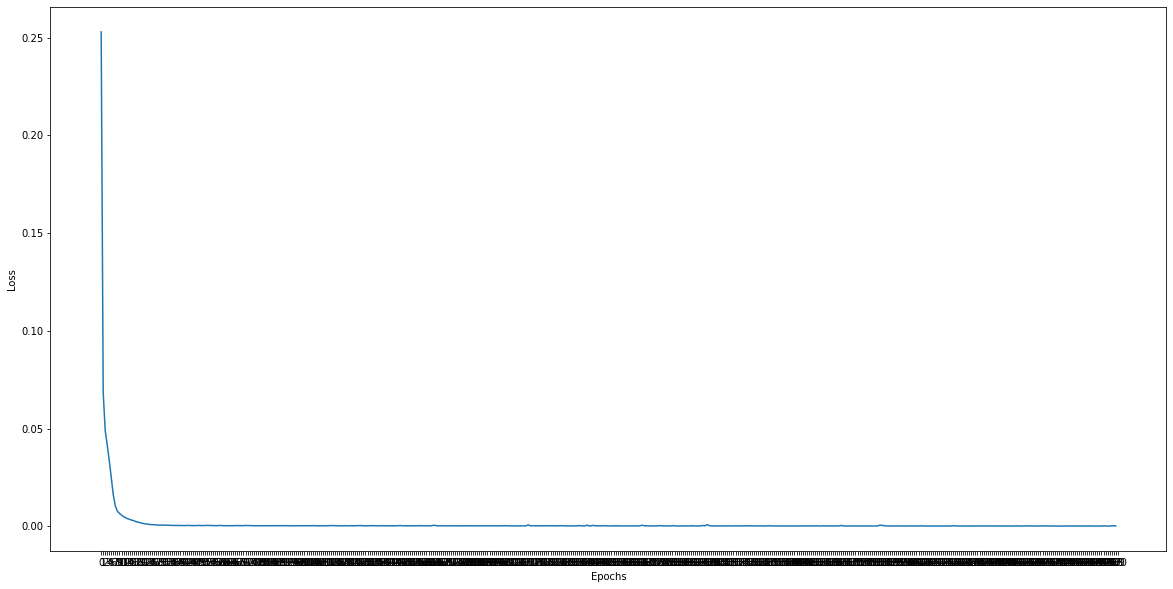

In [59]:
losses_lstm = model3.history.history['loss']
plt.figure(figsize=(20,10))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,501,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

### Predictions

In [60]:
predictions = model3.predict(X_test_std)

In [61]:
predictions = scaler3.inverse_transform(predictions)

In [62]:
y_train = pd.DataFrame(y_train)
y_train.index = df_train2.date
y_train

,0
date,
2013-05-17,1830.862569
2013-05-18,1785.110786
2013-05-19,1835.411812
2013-05-22,1913.842746
2013-05-23,1774.615773
...,...
2015-12-23,1246.257250
2015-12-26,1354.928727
2015-12-27,1287.226810


In [63]:
y_test = pd.DataFrame(y_test)
y_test.index = df_test2.date
y_test['Predictions'] = predictions

In [64]:
y_test

,daily_avg_price,Predictions
date,,
2016-01-02,1585.503660,1654.727905
2016-01-03,1197.702786,1181.428833
2016-01-06,1081.717213,1085.872437
2016-01-07,1249.007384,1247.344604
2016-01-08,1220.559891,1216.216309
...,...,...
2016-12-24,1018.571102,1033.916870
2016-12-28,1045.424358,1057.582642
2016-12-29,1034.546961,1048.248047


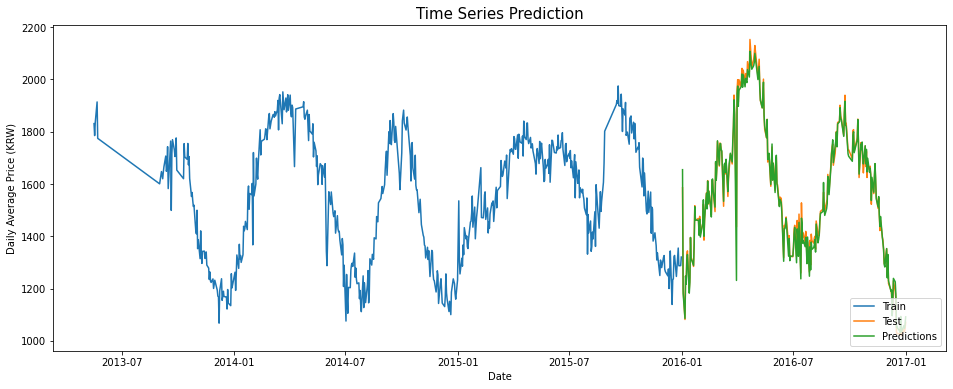

In [65]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Time Series Prediction', fontsize = 15)
plt.xlabel('Date')
plt.ylabel('Daily Average Price (KRW)')
plt.plot(y_train)
plt.plot(y_test[['daily_avg_price', 'Predictions']])
# plt.plot(predictions)
# plt.plot(df_test4[['daily_avg_price', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [66]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test.values) ** 2)))
rmse

14.925878441977364

In [67]:
r2_score(y_test.daily_avg_price, y_test.Predictions)

0.993385196540853

In [68]:
y_test.values.mean()

1572.19074223394

Using 31 features to predict `daily_avg_price` overpowers the performance of all other models we saw above. Not only do the features recover the general trend of the price, but also they are better at predicting the daily fluctuations. The model certainly overshot some of the predictions, such as the ones in January 2016 or around April 2016, but overall, the model does an outstanding job of recovering the observed time series. It also has the lowest RMSE than any other models that were fitted above. Given that the average observed price is 1572 KRW (approximately $1), the RMSE of 14 KRW (1 cent) seems to be a good value. The R^2 between the true price and the predicted price, 99%, is very high, which indicates that the model has a very good fit.

# <font color = "green">Part V </font> - Conclusion & Implications

In this project, I applied three different types of models to predict the daily average price of crop 9 across all wholesale markets in Korea. The ARIMA model served as the baseline and showed the poorest performance. The LSTM model fit on the multivariate data surpassed the benchmark and the univariate LSTM model with out-of-sample validation that uses the past price for prediction. There were two multivariate models with different hidden layer configurations, but the simpler network showed better performance. Thus, my final choice would be the LSTM model with 31 features and a single hidden layer.

Accurate crop price prediction plays an integral role in crop sourcing businesses. It helps identify arbitrage opportunities and achieve profit maximiztion. Traders can purchase the crops when they're cheapest and sell them when the price is at the peak based on the forecasting. Moreover, when the crop sourcing businesses make direct transactions with farmers, accurate price forecasting would improve the livelihood of the smallholder farmers who had been unable to sell their produce at full prices due to high price volatility. By gaining an insight that the crop price would increase, they can make sure that the crops get an accurate valuation just at the right time before, for example, there is a sudden decline in the price due to unusual macroeconomic or political conditions.

# <font color = "green">Part VI </font> - Future Work

1. In this project, I only narrowed down my focus on the crop with lowest price volatility. I would like to see if the LSTM model also does a good job of predicting volatile prices.
2. While using the original features in the data set already showed an outstanding predictive performance, I would like to examine if adding more features through feature engineering, such as days of week or season, would further improve the performance of the models. This would answer the question of whether knowing when the price occurred helps better predict the price in the future.
3. The potential of the model performance comes from the model flexibility. A model is flexible when it well represents the complex relationships in the data. However, the results showed that the deeper network architecture didn't necessarily enhance the performance of the LSTM model, although higher model complexity is expected to better capture noisy fluctuations in the time series. Adding more hidden layers certainly provides the possibility to learn more complex relationships in the data, but at the cost of increased search space. Dialing up the model flexibility increases the search space, which makes it harder to find the optimal solution. Given these trade-offs in using complex models, I would apply neural architecture search (NAS) algorithms in future work to find the optimal architecture for the LSTM models. Genetic programming might be useful for topological and numerical search for the size and structure of neural network models.